         region        category       parameter    mode powertrain  year  \
0     Australia      Historical        EV stock    Cars        BEV  2011   
1     Australia      Historical  EV sales share    Cars         EV  2011   
2     Australia      Historical  EV stock share    Cars         EV  2011   
3     Australia      Historical        EV sales    Cars        BEV  2011   
4     Australia      Historical        EV sales    Cars        BEV  2012   
...         ...             ...             ...     ...        ...   ...   
9537      World  Projection-APS        EV stock  Trucks       PHEV  2030   
9538      World  Projection-APS        EV stock    Vans        BEV  2030   
9539      World  Projection-APS        EV stock    Vans       PHEV  2030   
9540      World  Projection-APS        EV stock    Cars        BEV  2030   
9541      World  Projection-APS        EV stock    Cars       PHEV  2030   

          unit         value  
0     Vehicles  4.900000e+01  
1      percent  6.500000e

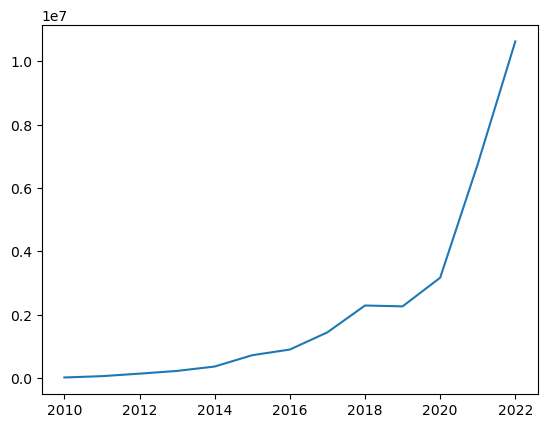

"\n\n\nplt.plot(result)       \nax.xaxis.get_data_interval()\nax.yaxis.get_data_interval()\nax.margins(0.05)\n#plt.tight_layout()\nplt.show() \n\n\nx = np.array([0,1,2,3])\ny = np.array([0.650, 0.660, 0.675, 0.685])\nmy_xticks = ['a', 'b', 'c', 'd']\nplt.xticks(x, my_xticks)\nplt.yticks(np.arange(y.min(), y.max(), 0.005))\nplt.plot(x, y)\nplt.grid(axis='y', linestyle='-')\n"

In [36]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("IEA Global EV Data 2023.csv")

#print(dataset)

#dataset.groupby(["region", "category", "parameter", "mode", "year"])["value"].sum()

#dataset.query("region == 'World'", "category='Historical'", "parameter='EV sales'", "year='2022").groupby(["region", "category", "parameter", "mode", "year"])["value"].sum()
#df.loc[(df['region'] == 'World') & (df['category'] == 'Historical') & (df['parameter'] == 'EV sales')].groupby(["region", "category", "parameter", "year"])["value"].sum()


result = df.loc[(df['region'] == 'World') & (df['category'] == 'Historical') & (df['parameter'] == 'EV sales')].groupby(["year"]).agg(EVSales=('value', 'sum'))


# plotting a line graph 
print("Line graph: ") 
#plt.plot(result["year"], result["EVSales"]) 
fig, ax = plt.subplots()
ax.plot(result)

print(ax.xaxis.get_data_interval())
print(ax.yaxis.get_data_interval())
plt.show()





'''


plt.plot(result)       
ax.xaxis.get_data_interval()
ax.yaxis.get_data_interval()
ax.margins(0.05)
#plt.tight_layout()
plt.show() 


x = np.array([0,1,2,3])
y = np.array([0.650, 0.660, 0.675, 0.685])
my_xticks = ['a', 'b', 'c', 'd']
plt.xticks(x, my_xticks)
plt.yticks(np.arange(y.min(), y.max(), 0.005))
plt.plot(x, y)
plt.grid(axis='y', linestyle='-')
'''